# Testing the E2E simulations

## -- LUVOIR A aperture --

I am creating this notebook at a point where I have finally figured out how to connect the APLC propagation in `HCIPy` with the segmented mirror (SM) from HCIPy, which is currently still a pull request (PR) on GitHub but fully functinoal on it.

**Required files**

This LUVOIR simulator is set up in a way that is agnostic to the aperture and coronograph we use, as long as a couple of very specific input files are provided. We are currently limited to an Apodized Pupil Lyot Coronagraph, but I intend to extend this in the future. The files we need to make the current version work are:

- **segmented aperture** fits file: This is the entrance pupil of the segmented telescope and needs to come together with the apodizer ad Lyot stop files. This file is not actually needed for the propagation (because we need to have `(aper x apod) - apod = 0`), but it will always be one of the main files in an APLC optimization run.
- **indexed segmented aperture** fits file with **segment positions**: This is a copy of the segmented aperture file except that each segment is filled with its number value, i.e. segment 1 will be filled with ones instead of zeros, segmente two will be filled with twos and so on. Additionally, this file needs to have all segments' x and y (center) position saved in its fits header.
- **apodizer** fits file: This needs to be a file that if overlapped directly with the segmented entrance aperture, it must work. It doesn't matter if it is a perfect fit or if the apodizer is slightly undersized to make sure there are not errors on the edges. `(aper x apod) - apod = 0` needs to be true.
- **Lyot stop** fits file: As the apodizer, this needs to come as a part of the aperture-apodizer-lyot stop package to the pixel level.

I will first set up the entire system and show how to aberrate the segmented mirror and then hopefully find a way of modularizing it all together so that I can use it in an easier way for PASTIS.

In [ ]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.units as u
from astropy.io import fits
%matplotlib inline
import hcipy as hc
from hcipy.optics.segmented_mirror import SegmentedMirror

In [ ]:
# General telescope parameters
nseg = 120
wvln = 638e-9 # m
diam = 15. # m

# Coronagraph parameters
# The LUVOIR STDT delivery in May 2018 included three different apodizers
# we can work with, so I will implement an easy way of making a choice between them.
design = 'small'
datadir = '/Users/ilaginja/Documents/LabWork/ultra/LUVOIR_delivery_May2019/'
apod_dict = {'small': {'pxsize': 1000, 'fpm_rad': 3.5, 'fpm_px': 150, 'iwa': 3.4, 'owa': 12.,
                       'fname': '0_LUVOIR_N1000_FPM350M0150_IWA0340_OWA01200_C10_BW10_Nlam5_LS_IDD0120_OD0982_no_ls_struts.fits'},
             'medium': {'pxsize': 1000, 'fpm_rad': 6.82, 'fpm_px': 250, 'iwa': 6.72, 'owa': 23.72,
                        'fname': '0_LUVOIR_N1000_FPM682M0250_IWA0672_OWA02372_C10_BW10_Nlam5_LS_IDD0120_OD0982_no_ls_struts.fits'},
             'large': {'pxsize': 1000, 'fpm_rad': 13.38, 'fpm_px': 400, 'iwa': 13.28, 'owa': 46.88,
                       'fname': '0_LUVOIR_N1000_FPM1338M0400_IWA1328_OWA04688_C10_BW10_Nlam5_LS_IDD0120_OD0982_no_ls_struts.fits'}}

pup_px = apod_dict[design]['pxsize']
fpm_rad = apod_dict[design]['fpm_rad']  # lambda/D
fpm_px = apod_dict[design]['fpm_px']
samp_foc = fpm_px / (fpm_rad * 2)   # sampling of focal plane mask
iwa = apod_dict[design]['iwa']   # lambda/D
owa = apod_dict[design]['owa']  # lambda/D

# Image system parameters
im_lamD = 1.2 * owa     # image half-size in lambda/D
sampling = 4

# Print some of the defined parameters
print('LUVOIR apodizer design: {}'.format(design))
print()
print('Wavelength: {} m'.format(wvln))
print('Telescope diameter: {} m'.format(diam))
print('Number of segments: {}'.format(nseg))
print()
print('IWA: {} lambda/D'.format(iwa))
print('OWA: {} lambda/D'.format(owa))
print('Pupil size: {} pixels'.format(pup_px))
print('Image size: {} lambda/D'.format(im_lamD))
print('Sampling: {} px per lambda/D'.format(sampling))
print('FPM radius: {} lambda/D'.format(fpm_rad))
print('Pixels in FPM: {} pixels'.format(fpm_px))

##  Preparing the optical system

### Pupil plane optics from file

Reading the segmented aperture, indexed aperture, apodizer and Lyot stop from fits into **numpy arrays**.

In [ ]:
aper_path = 'inputs/TelAp_LUVOIR_gap_pad01_bw_ovsamp04_N1000.fits'
aper_ind_path = 'inputs/TelAp_LUVOIR_gap_pad01_bw_ovsamp04_N1000_indexed.fits'
apod_path = os.path.join(datadir, 'luvoir_stdt_baseline_bw10', design+'_fpm', 'solutions',
                          apod_dict[design]['fname'])
ls_fname = 'inputs/LS_LUVOIR_ID0120_OD0982_no_struts_gy_ovsamp4_N1000.fits'

pup_read = hc.read_fits(os.path.join(datadir, aper_path))
aper_ind_read = hc.read_fits(os.path.join(datadir, aper_ind_path))
apod_read = hc.read_fits(os.path.join(datadir, apod_path))
ls_read = hc.read_fits(os.path.join(datadir, ls_fname))

plt.figure(figsize=(15, 15))
plt.suptitle('Display pupil numpy arrays')
plt.subplot(221)
plt.imshow(pup_read)
plt.title('Segmented aperture')
plt.subplot(222)
plt.imshow(aper_ind_read)
plt.title('Indexed aperture')
plt.subplot(223)
plt.imshow(apod_read)
plt.title('Apodizer')
plt.subplot(224)
plt.imshow(ls_read)
plt.title('Lyot stop')

We need to cast them into HCIPy's `Field` class instances.

In [ ]:
pupil_grid = hc.make_pupil_grid(dims=pup_px, diameter=diam)

aperture = hc.Field(pup_read.ravel(), pupil_grid)
aper_ind = hc.Field(aper_ind_read.ravel(), pupil_grid)
apod = hc.Field(apod_read.ravel(), pupil_grid)
ls = hc.Field(ls_read.ravel(), pupil_grid)

plt.figure(figsize=(15, 15))
plt.suptitle('Display pupil HCIPy Fields')
plt.subplot(221)
hc.imshow_field(aperture)
plt.title('Segmented aperture')
plt.subplot(222)
hc.imshow_field(aper_ind)
plt.title('Indexed aperture')
plt.subplot(223)
hc.imshow_field(apod)
plt.title('Apodizer')
plt.subplot(224)
hc.imshow_field(ls)
plt.title('Lyot stop')

Moreover, the **apodizer** and **Lyot stop** have to be made into an actual optical element to be able to act on wavefronts. Although I realized later that I don't actually need this in the setup that I chose to use.

In [ ]:
apodizer = hc.Apodizer(apod)
lyotstop = hc.Apodizer(ls)

### Segment positions

They're saved individually in the header of the indexed aperture fits file. The resulting list of segment positions needs to have the format `(2, nseg)`.

In [ ]:
# Load segment positions from fits header
hdr = fits.getheader(os.path.join(datadir, aper_ind_path))

poslist = []
for i in range(nseg):
    segname = 'SEG' + str(i+1)
    xin = hdr[segname + '_X']
    yin = hdr[segname + '_Y']
    poslist.append((xin, yin))
    
poslist = np.transpose(np.array(poslist))
print(poslist.shape)

We need to cast this into a `CartesianGrid` - note how the dimensionality gets reversed.

In [ ]:
# Cast into HCIPy CartesianCoordinates (because that's what the SM needs)
seg_pos = hc.CartesianGrid(poslist)
print(type(seg_pos))
print(seg_pos.points.shape)

### Segmented mirror

The segmented mirror needs the indexed aperture and the segment positions as an input, which allows it to work on any arbitrary segmented telescope.

In [ ]:
# Instantiate the SM
sm = SegmentedMirror(aper_ind, seg_pos)

We can display the segment numbers, which is important to be able to identify which segment we are controlling. This is supposed to be a class method, but is not yet.

In [ ]:
# Show the SM with segment numbering
plt.figure(figsize=(10, 10))
hc.imshow_field(aper_ind)
for i, par in enumerate(seg_pos):
    pos = par * diam
    plt.annotate(s=i+1, xy=pos, xytext=pos, color='white', fontweight='bold', fontsize=15)

### Focal plane mask

In [ ]:
# Make focal grid for FPM
focal_grid_fpm = hc.make_focal_grid(pupil_grid=pupil_grid, q=samp_foc, num_airy=fpm_rad, wavelength=wvln)

Since we're using actual physical units for our telescope diameter and wavelength, one $\lambda/D$ in our focal planes will also have a non-unit size. We need to knowo what that is (in units of radians).

In [ ]:
# Let's figure out how much 1 lambda/D is in radians (needed for focal plane)
lam_over_d = wvln / diam  # rad
print('Wavelength = {} m'.format(wvln))
print('Telescope diameter = {} m'.format(diam))
print('1 lambda/D = {} rad'.format(lam_over_d))

In [ ]:
# Create FPM on a focal grid, with radius in lambda/D
fpm = 1 - hc.circular_aperture(2*fpm_rad*lam_over_d)(focal_grid_fpm)

# Display the FPM
hc.imshow_field(fpm)
plt.title('Focal plane mask')

## Optical system propagation

The goal of this section is to aberrate some segments and get a focal plane image. At the heart of this lie the wavefronts in the different planes that are directly accessible:

*Full system:*
- `wf_sm`: at the SM pupil plane, to see what aberrations are applied to the SM
- `wf_apod`: pupil plane with **SM** (equivalent to entrance pupil) and apodizer
- `wf_lyot`: Lyot plane **after** SA propagation and **after** Lyot stop
- `wf_im_coro`: image plane after coronagraph propagation

*Reference image:*
- `wf_ref_pup`: pupil plane with entrance aperture (not the SM!), apodizer and Lyot stop (FPM left out) for reference image
- `wf_im_ref`: image plane for reference image without the FPM

*Extra planes within the full system:*
- `wf_aper`: at the aperutre, solely used to be abble to propagate the SM
- `wf_before_fpm`: focal plane directly before the FPM
- `int_after_fpm`: focal plane directly after the FPM - directly the intensity, because that is easier to get for this plane
- `wf_before_lyot`: pupil plane in Lyot plane right before Lyot stop

This image shows all the wavefronts in their respective plane. The ones in black font indicate the wavefronts that are always necessary for a full APLC propagation with the SA method, the blue font wavefronts are the extra planes we might chose to generate to be able to plot them, and the two wavefronts that are circled in read indicate what we need if we want to display the phase on a segmented mirror.

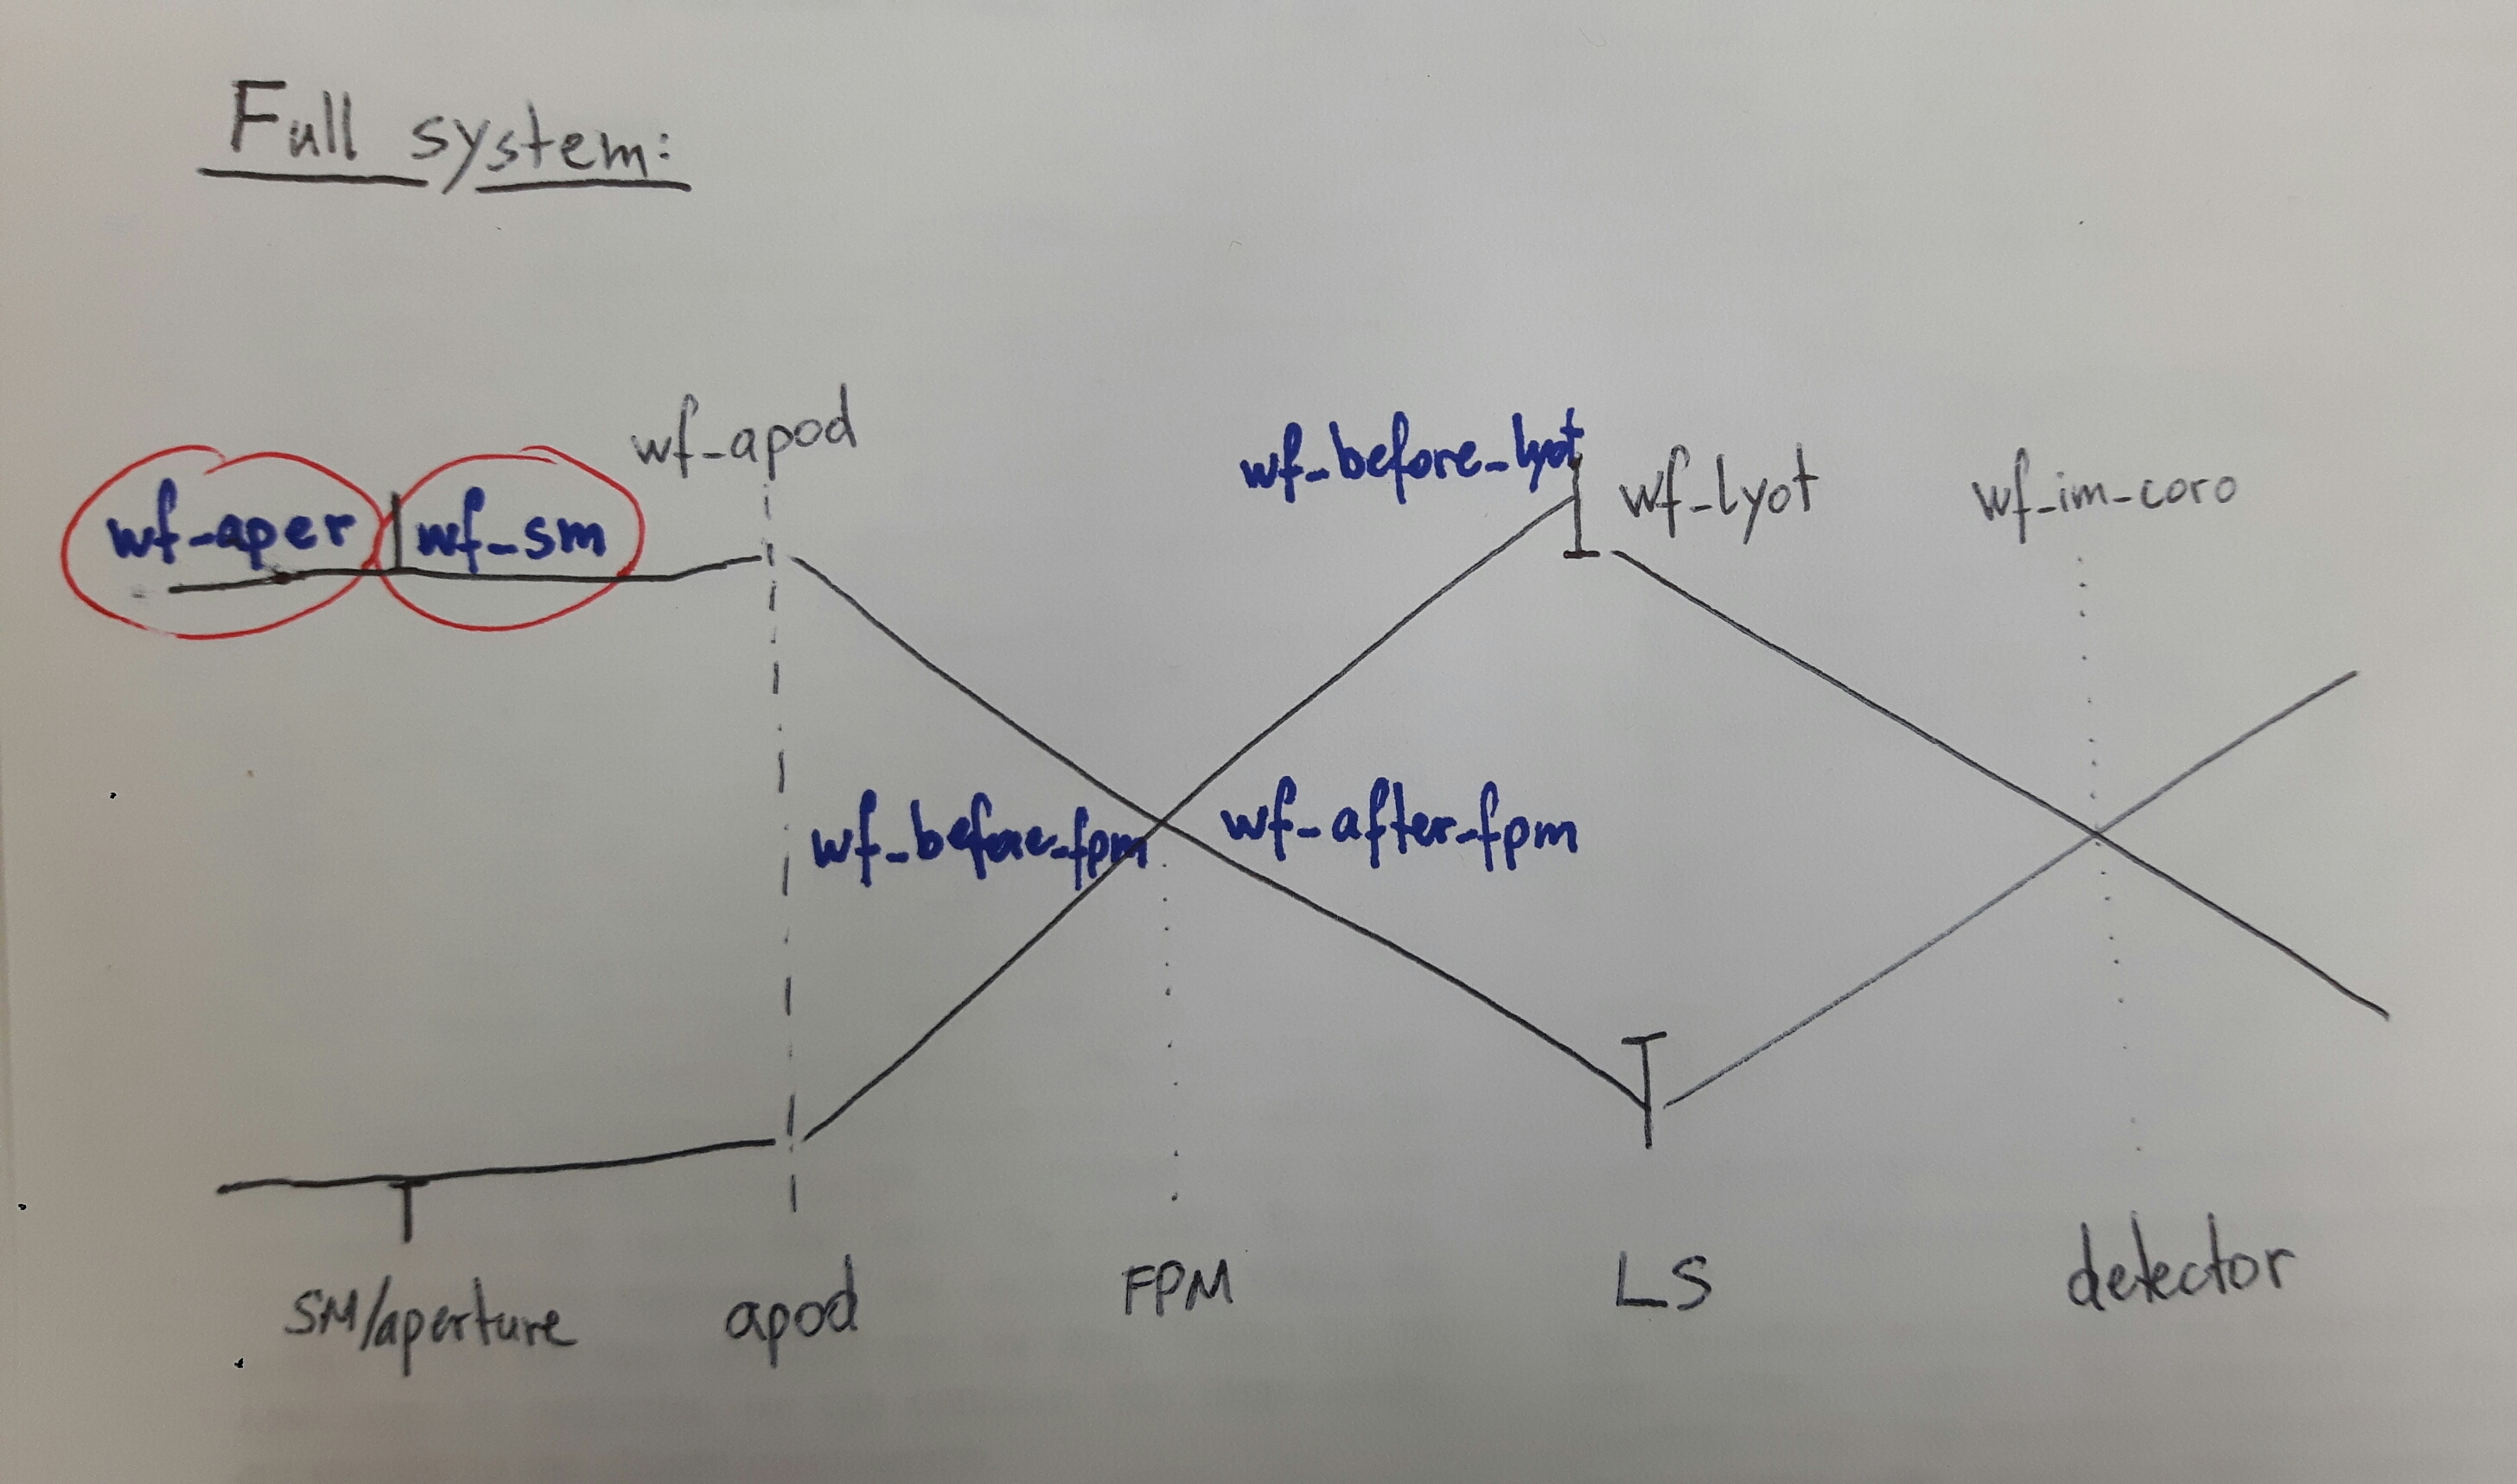

This image indicates how we can think of the system when we calculate the reference image. Since the FPM is taken out, we can eliminate the propagations through that focal plane and stack the aperture, apodizer and LS in one pupil plane, that then only needs one simple propagation to the detector image plane.

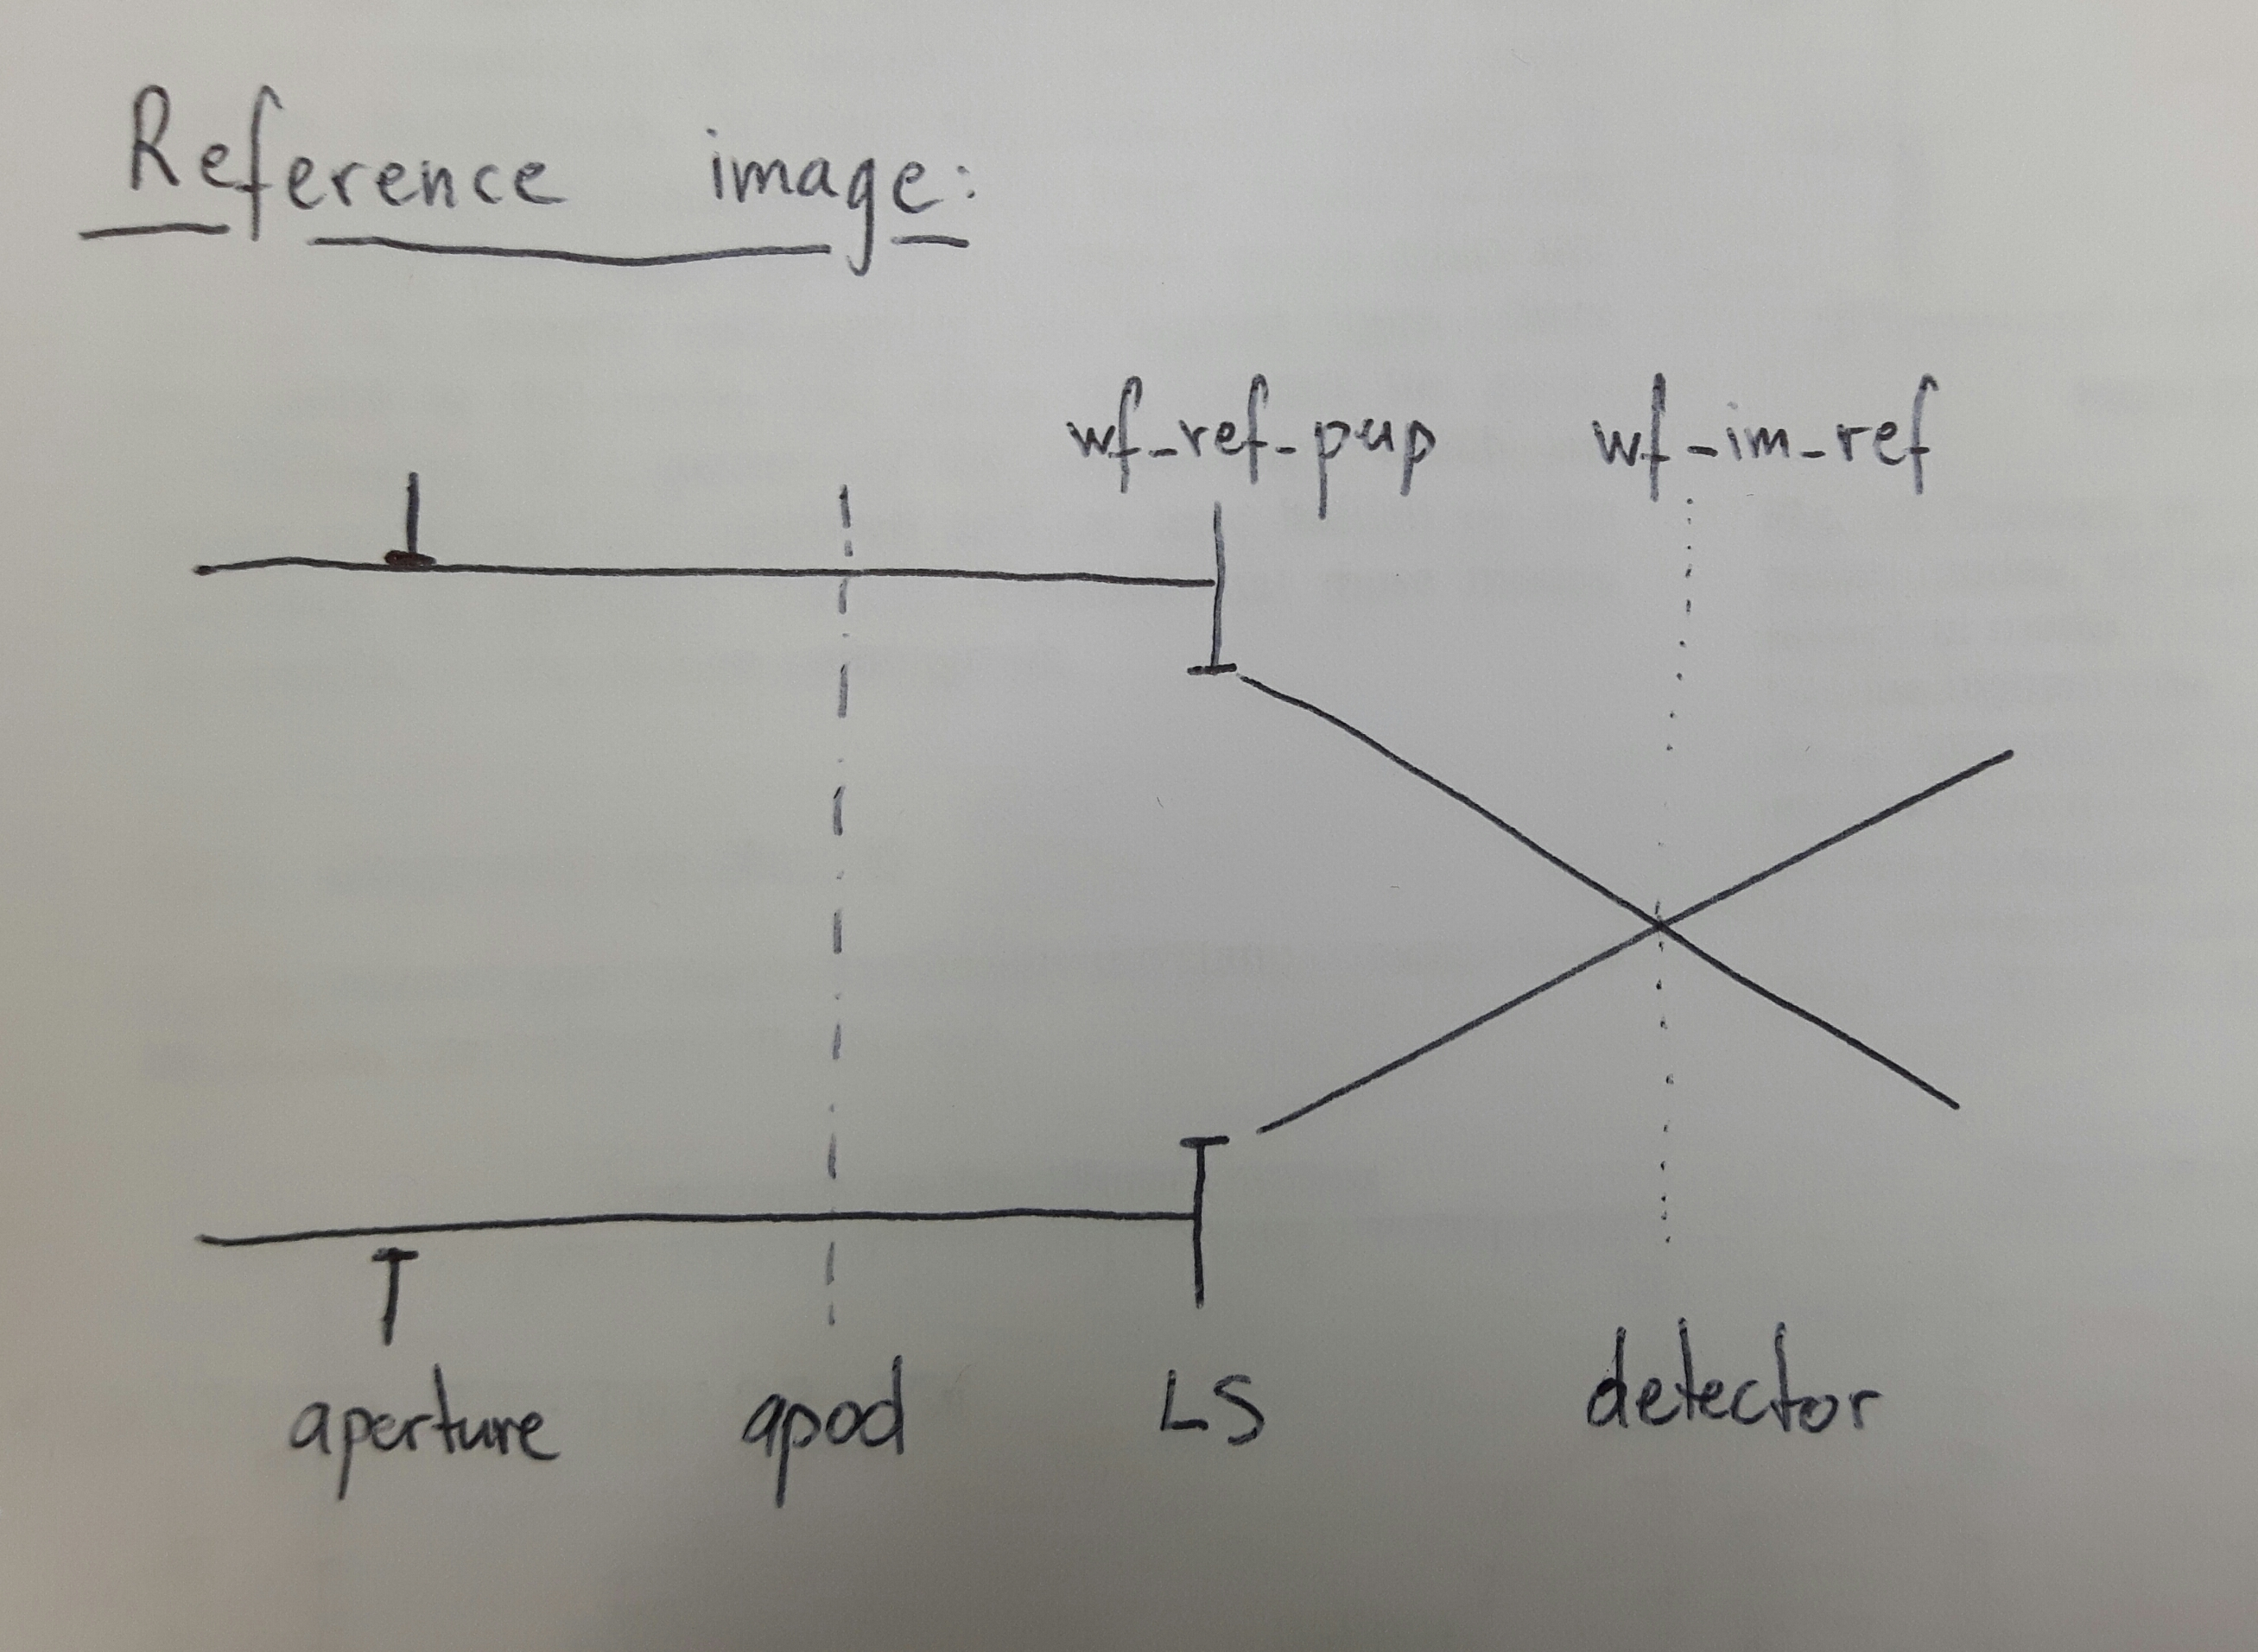

#### Create the extra focal grids

We need one focal grid for the detector plane.

In [ ]:
# Detector plane focal grid
focal_grid_det = hc.make_focal_grid(pupil_grid=pupil_grid, q=sampling, num_airy=im_lamD, wavelength=wvln)

If we want to be able to overplot the FPM with the PSF in that focal plane, we will need to create an additional FPM that we only use for plotting purposes. The FPM we created above is specific to the SA propagation and won't match the PSF grid, so we cannot overplot them.

In [ ]:
fpm_plot = 1 - hc.circular_aperture(2 * fpm_rad * lam_over_d)(focal_grid_det)

#### Create propagators

In [ ]:
# Full Lyot coro system from pupil to Lyot plane
coro = hc.LyotCoronagraph(pupil_grid, fpm, ls)   # this propagator needs the LS *Field*, not the Apodizer() object

# Direct propagation from pupil plane to detector-like focal plane
prop = hc.FraunhoferPropagator(pupil_grid, focal_grid_det)

# Lyot coronagraph propagator without applying LS, for extra plane
coro_no_ls = hc.LyotCoronagraph(pupil_grid, fpm)

### Aberrate the SM

The fastest way to aberrate the SM is to create a list of segments to be aberrated and then apply the same aberration wiht the same amplitude to all of them. I will need to write some methods and functions that facilitate this, but for now this will do.

The SM takes the mirror surface aberration as input, so if we want to define our aberration amplitude in radians, we can convert it first to OPD with this function:

In [ ]:
def aber_to_opd(aber_rad, wvln):
    aber_m = aber_rad * wvln / (2 * np.pi)
    return aber_m

And since it takes meters of surface, we need to divide the OPD by two before we sent the command off to the SM.

In [ ]:
aber_seg = [1, 14, 16, 23, 28, 46, 120, 104, 96, 84]
opd_m = 1e-9   # I decided I want to define my aberration in meters of OPD. Remember divide by 2 for the SM!

sm.flatten()
for aseg in aber_seg:
    pass#sm.set_segment(aseg, opd_m/2, 0, 0)
    
wf_aper = hc.Wavefront(aperture, wavelength=wvln)   # this wf is always the same, no matter what else we change
wf_sm = sm(wf_aper)

# Display SM phase
plt.figure(figsize=(10, 10))
hc.imshow_field(wf_sm.phase, mask=aperture, cmap='RdBu')
plt.title('Wavefront phase at SM')
plt.colorbar()

### Create the wavefronts

We will now proceed in creating all the wavefronts listed above. This is essentially the last step in the full propagation, as for anything after that we just access the attributes of the wavefronts, mostly phase or intensity.

In [ ]:
# All wavefronts of the full propagation
wf_sm = sm(wf_aper)
wf_apod = apodizer(wf_sm)
wf_lyot = coro(wf_apod)
wf_im_coro = prop(wf_lyot)

In [ ]:
# Wavefronts of the reference propagation
wf_ref_pup = hc.Wavefront(apod * ls, wavelength=wvln)   # using the Fields here instead of the Apodizer() objects for apod and ls
wf_im_ref = prop(wf_ref_pup)

# This is our normalizaiton factor for image plane images.
# All other images will be normalized by their own peak.
norm = wf_im_ref.intensity.max()

In [ ]:
wf_before_fpm = prop(wf_apod)
int_after_fpm = np.log10(wf_before_fpm.intensity/norm) * fpm_plot   # this is the intensity straight
wf_before_lyot = coro_no_ls(wf_apod)
# wf_aper generated above

### Display all planes

In [ ]:
plt.figure(figsize=(15, 15))

plt.subplot(331)
hc.imshow_field(wf_sm.phase, mask=aperture, cmap='RdBu')
plt.title('Seg aperture phase')

plt.subplot(332)
hc.imshow_field(wf_apod.intensity, cmap='inferno')
plt.title('Apodizer')

plt.subplot(333)
hc.imshow_field(wf_before_fpm.intensity/wf_before_fpm.intensity.max(), norm=LogNorm(), cmap='inferno')
plt.title('Before FPM')

plt.subplot(334)
hc.imshow_field(int_after_fpm/wf_before_fpm.intensity.max(), cmap='inferno')
plt.title('After FPM')

plt.subplot(335)
hc.imshow_field(wf_before_lyot.intensity/wf_before_lyot.intensity.max(), norm=LogNorm(vmin=1e-3, vmax=1), cmap='inferno')
plt.title('Before Lyot stop')

plt.subplot(336)
hc.imshow_field(wf_lyot.intensity/wf_lyot.intensity.max(), norm=LogNorm(vmin=1e-3, vmax=1), cmap='inferno', mask=ls)
plt.title('After Lyot stop')

plt.subplot(337)
hc.imshow_field(wf_im_coro.intensity/norm, norm=LogNorm(vmin=1e-10, vmax=1e-3), cmap='inferno')
plt.title('Final image')
plt.colorbar()

In [ ]:
hc.imshow_field(wf_im_coro.intensity/norm, norm=LogNorm(vmin=1e-10, vmax=1e-3), cmap='inferno')
plt.colorbar()
#fits.writeto('dh_unaberrated.fits', (wf_im_coro.intensity/norm).reshape(wf_im_coro.intensity.shaped.shape))

# LUVOIR simulator class

What we want to do next is setting this up in a class that we can call as a whole instead of having to run through all the cells from above. For now, the only thing it has to be able to do is to take in segment aberrations and spit out the images.

In [ ]:
# I developed this class in here, but now it's in a module in the PASTIS repo,
# so I will import it from there
os.chdir('../../pastis')
from e2e_simulators.luvoir_imaging import SegmentedTelescopeAPLC

In [ ]:
# Create parameter dictionary
luvoir_params = {'wavelength': wvln, 'diameter': diam, 'imlamD': im_lamD, 'fpm_rad': fpm_rad}

In [ ]:
# Instantiate LUVOIR telescope with APLC
luvoir = SegmentedTelescopeAPLC(aperture, aper_ind, seg_pos, apod, ls, fpm, focal_grid_det, luvoir_params)

In [ ]:
# Get coro PSF, ref PSF and intermediate planes
im, ref, inter = luvoir.calc_psf(ref=True, display_intermediate=True, return_intermediate='intensity')

Try aberrating the SM and regenerate the PSF.

In [ ]:
aber_seg = [2, 13, 20, 32, 27, 53, 102, 107, 111, 119]
opd_m = 1e-9   # I decided I want to define my aberration in meters of OPD. Remember to divide by 2 for the SM!

luvoir.flatten()
for aseg in aber_seg:
    pass#luvoir.set_segment(aseg, opd_m/2, 0, 0)

In [ ]:
im, ref, inter = luvoir.calc_psf(ref=True, display_intermediate=True, return_intermediate=True)

In [ ]:
print(inter.keys())

In [ ]:
hc.imshow_field(inter['seg_mirror'], mask=aperture, cmap='RdBu')

## Dark hole mask

In [ ]:
dh_outer = hc.circular_aperture(2*owa * lam_over_d)(focal_grid_det)
dh_inner = hc.circular_aperture(2*iwa * lam_over_d)(focal_grid_det)
dh_mask = (dh_outer - dh_inner).astype('bool')

plt.figure(figsize=(18, 6))
plt.subplot(131)
hc.imshow_field(im/ref.max(), norm=LogNorm())
plt.subplot(132)
hc.imshow_field(dh_mask)
plt.subplot(133)
hc.imshow_field(im/ref.max(), norm=LogNorm(), mask=dh_mask)

In [ ]:
dh_intensity = im/ref.max() * dh_mask
contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)])
print('contrast:', contrast)

Baseline contrasts:


Small: 4.21e-11

Medium: 3.87e-11

Large: 3.82e-11